In [66]:
### IMPORTS ###
# Quantum libraries:
from qiskit import BasicAer, QuantumCircuit
from qiskit.algorithms.minimum_eigen_solvers.minimum_eigen_solver import MinimumEigensolver
from qiskit.algorithms.variational_algorithm import VariationalAlgorithm
from qiskit.opflow import Z, I, X

# Other
import numpy as np
import pylab
import copy
import pylatexenc # Circuit visualization

In [67]:
# Parameters:
N = 8                             # Number of spins
J = 1                             # Interaction strenght
n_lams = 100                      # Number of lambas
lams = np.linspace(0,2*J, n_lams) # Magnetic field strenght array 

# Training Parameters:
epochs1 = 500
epochs  = 50


In [76]:
def qiskit_build_H(N, lam, J):
    # Interaction with the magnetic field
    H = Z
    for _ in range(1,N):
        H = H ^ I
    
    for spin in range(1,N):
        z = I
        for sx_spin in range(0, spin):
            z 
    
    H = lam * H
    
    return H

In [77]:
a = qiskit_build_H(8, 1, 1)

In [63]:
def qiskit_vqe_circuit(N, params, shift_invariant = 0):
    '''
    shift_invariant = 0: Each wire permorms independent rotations.
    shift_invariant = 1: Same rotation for odd and even wires,
                         expect for the first and last that have unique
                         rotation.
    shift_invariant = 2: Same rotation for each wire
    '''
    # Create a Quantum Circuit
    circ = QuantumCircuit(N)
    
    if shift_invariant == 0:
        n_params = 5* N
        if n_params != len(params):
            raise ValueError('invalid input parameters')
        
        # Apply RX and RY to each wire:
        for spin in range(N):
            circ.ry(params[spin], spin)
            circ.rx(params[N+spin], spin)
            
        # Apply entanglement to neighbouring spins:
        for spin in range(0,N-1,2):
            circ.cnot(spin, spin+1)
        for spin in range(1,N-1,2):
            circ.cnot(spin, spin+1)
        
        circ.barrier()
        
        # Apply RX and RY to each wire:
        for spin in range(N):
            circ.ry(params[2*N+spin], spin)
            circ.rx(params[3*N+spin], spin)
            
        # Apply entanglement to neighbouring spins:
        for spin in range(0,N-1,2):
            circ.cnot(spin, spin+1)
        for spin in range(1,N-1,2):
            circ.cnot(spin, spin+1)
            
        circ.barrier()
        
        # Apply final RY to each wire:
        for spin in range(N):
            circ.ry(params[4*N+spin], spin)
        
    elif shift_invariant == 1:
        n_params = 20
        if n_params != len(params):
            raise ValueError('invalid input parameters')
            
        # Apply RX and RY to each wire:
        circ.ry(params[0], 0)
        circ.rx(params[1], 0)
        circ.ry(params[2], N-1)
        circ.rx(params[3], N-1)
        for spin in range(1,N-1,2):
            circ.ry(params[4], spin)
            circ.rx(params[5], spin)
        for spin in range(2,N-1,2):
            circ.ry(params[6], spin)
            circ.rx(params[7], spin)
            
        # Apply entanglement to neighbouring spins:
        for spin in range(1,N-1,2):
            circ.cnot(spin, spin+1)
        for spin in range(2,N-1,2):
            circ.cnot(spin, spin+1)
        
        circ.barrier()
        
        # Apply RX and RY to each wire:
        circ.ry(params[8], 0)
        circ.rx(params[9], 0)
        circ.ry(params[10], N-1)
        circ.rx(params[11], N-1)
        for spin in range(1,N-1,2):
            circ.ry(params[12], spin)
            circ.rx(params[13], spin)
        for spin in range(2,N-1,2):
            circ.ry(params[14], spin)
            circ.rx(params[15], spin)
            
        # Apply entanglement to neighbouring spins:
        for spin in range(0,N-1,2):
            circ.cnot(spin, spin+1)
        for spin in range(1,N-1,2):
            circ.cnot(spin, spin+1)
            
        circ.barrier()
        
        # Apply final RY to each wire:
        circ.ry(params[16], 0)
        circ.ry(params[17], N-1)
        for spin in range(1,N-1,2):
            circ.ry(params[18], spin)
        for spin in range(2,N-1,2):
            circ.ry(params[19], spin)
            
    elif shift_invariant == 2:
        n_params = 5
        # Apply RX and RY to each wire:
        for spin in range(N):
            circ.ry(params[0], spin)
            circ.rx(params[1], spin)
            
        # Apply entanglement to neighbouring spins:
        for spin in range(0,N-1,2):
            circ.cnot(spin, spin+1)
        for spin in range(1,N-1,2):
            circ.cnot(spin, spin+1)
        
        circ.barrier()
        
        # Apply RX and RY to each wire:
        for spin in range(N):
            circ.ry(params[2], spin)
            circ.rx(params[3], spin)
            
        # Apply entanglement to neighbouring spins:
        for spin in range(0,N-1,2):
            circ.cnot(spin, spin+1)
        for spin in range(1,N-1,2):
            circ.cnot(spin, spin+1)
        
        circ.barrier()
        
        # Apply final RY to each wire:
        for spin in range(N):
            circ.ry(params[4], spin)
            
    else:
        raise ValueError('Invalid input for shift_invariant parameter')
        
    return circ

In [64]:
circuit = qiskit_vqe_circuit(8, np.arange(5), shift_invariant = 2)

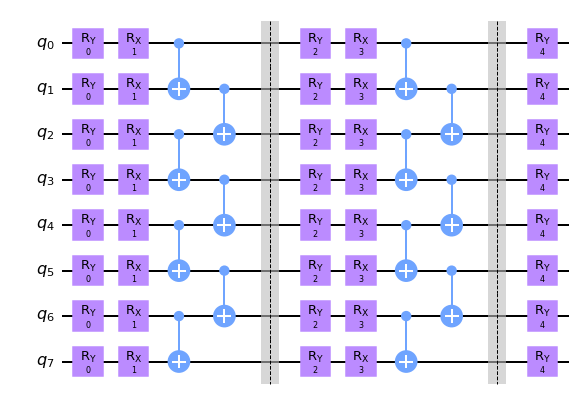

In [65]:
circuit.draw(output='mpl')